# Predicting telemarketing success in the banking sector: the case of Portuguese bank (Part II)

Alexander Kalita

# Introduction

The first part of the Portuguese bank deposit project primarily focused on Machine Learning (ML) model development [1]. This phase encompasses essential steps such as data cleaning, feature engineering, and model training and interpretation.

However, the true value of the ML model lies in its practical implementation, which necessitates the adoption of Machine Learning Operations (MLOps) principles. This critical component covers tasks such as model development, deployment and management in diverse environment settings.

In essence, the project offers an end-to-end solution for predicting future bank deposit subscriptions resulting from a marketing campaign conducted by the Portuguese bank. The ML model is presented as a simple and interactive application named Depositer, accessible through an online web domain.

The Depositer application addresses a common challenge encountered by deposit marketers: inefficient allocation of marketing budgets towards targeting customers who are unlikely to subscribe to term deposits. It accurately identifies the desired customer group and optimizes telemarketing campaigns.

The study concludes by highlighting the challenges associated with Data, ML algorithms and modern MLOps practices in achieving tangible business outcomes.

# Model design

In this section, the design considerations of the ML Depositer application were explored, utilizing the ML canvas framework to systematically address key aspects [2]. 


First, the following facets of product design that were taken into account:

**Background**. The Depositer application is designed to assist marketers in targeting potential subscribers during deposit marketing campaigns. By doing so, it helps to minimize the inefficiencies associated with identifying the desired customer group.

**Value proposition**. Depositer utilizes various customer features such as age, occupation, and call duration to differentiate potential bank deposit subscribers from non-subscribers. By leveraging this predictive capability, users can optimize their marketing efforts by targeting individuals more likely to subscribe, thereby saving time and marketing resources that would otherwise be spent on individually contacting every customer.

**Objectives**. The key objective of Depositer is to identify potential subscribers for a bank deposit.

**Solution**. The Depositer application fulfills its primary objective by providing fast predictions with low latency (<100ms). Additionally, it offers a user-friendly minimalistic UI interface for ease of use, and ensures the security of the website with HTTPS encryption.

**Feasibility**. Depositer is designed as a prototype with all the necessary resources readily available for its development.

When discussing the system design, it is crucial to cover the following aspects:

**Data**. The Depositer ML model utilizes a dataset of 45,211 instances, encompassing socio-demographic characteristics, financial backgrounds, and telemarketing campaign interactions. This dataset was sourced from a Portuguese retail bank between May 2008 and November 2010 and is publicly available in the UCI Machine Learning Repository [3].

**Metrics**. Focusing on the balance of metrics was key, resulting in notable achievements such as an 88.4% accuracy rate and an 85% Area Under the Curve (AUC) for the Receiver Operating Characteristic (ROC), effectively distinguising potential subscribers from non-subscribers. Additionally, the model successfully identified 80% of potential subscribers while minimizing false positives to just 10%.

**Evaluation**. Offline evaluation involved splitting the dataset into training and testing subsets using a 70%/30% ratio. During model training, 5-fold cross-validation was conducted, dividing the data into 5 samples. Each sample demonstrated a cross-validation accuracy of around 91% (with a margin of ±1%). For online evaluation, the model's performance is continuously assessed in real-world settings by making predictions using various features outlined in the Depositer application.

**Modeling**. The approach to modeling Depositer involved initial manual testing of core model aspects in a local environment, followed by execution in the production environment with 1-2 user tests. Once functionality was confirmed, focus shifted to automation and increased user testing in the production cloud. Continuous feedback and prompt error resolution were prioritized throughout the iterative process.

**Inference**. Depositer operates by processing batch predictions, where multiple input data points are sent to the Flask server at once, and predictions for all these data points are calculated simultaneously. Users initiate requests via the UI interface and promptly receive prediction values in response.

**Feedback**.  A robust system has been implemented to automatically gather feedback across various aspects of the Depositer application. 
This system is designed for quick problem-solving during production.

**Project**. Depositer was developed entirely by a single developer, covering all aspects from inception to management.

# Project architecture

The MLOps architecture of the Depositer application consists of two main parts. The first part covers solely on data exploration and analysis, detailed in a separate file [1]. The second part, which is the focus of this project, encompasses all other components of the pipeline. Each aspect of the Depositer MLOps pipeline will be discussed below.

The project pipeline begins with the upload of the dataset and exploratory data analysis conducted in JupyterLab, where the XGBoost model emerged as the best trained model. This initial phase constitutes the first part of the project.

Subsequently, the trained XGBoost model underwent version control using Git, and various experiments were conducted with MLflow in a pipenv virtual environment. The model was locally tested using a Flask server in the local environment, and important feature reliability tests, such as explanations with SHAP values and bias feature assessment, were carried out. Additionally, the model was then tested in a local environment using a Streamlit UI to showcase the Depositer application online.

Moving to the pre-production stage, the focus was on deploying the model in a production-ready environment. This involved deploying the model on Gunicorn and Streamlit servers, which were thoroughly tested. The servers were containerized using Docker, connected with Docker Compose, and pushed to an online container repository on Docker Hub.

Terraform was employed to automate the setup of the AWS cloud environment and prepare various AWS services for the production deployment of Depositer. These AWS services complemented the core project components deployed on the AWS Elastic Kubernetes Service (EKS) cluster.

The EKS cluster was hosted on virtual AWS servers (Elastic Cloud Compute - EC2), where Gunicorn and Streamlit servers were deployed. Traefik reverse proxy was installed using Helm, along with the Traefik dashboard and ExternalDNS, facilitating the management of Depositer application predictions online.

Finally, the management component of the project encompasses all other project parts, maintaining version control with Git, pushing the project to an online repository on GitHub, and automating Continuous Integration and Continuous Deployment (CI/CD) using GitHub Actions, thereby establishing a comprehensive MLOps pipeline.

In [1]:
# Display MLOps pipeline architecture
from IPython.display import IFrame
diagram_path = 'C:/Users/Alexander_Kalita/Desktop/Depositer_MLOps_pipeline.html'
IFrame(diagram_path, width=800, height=600)

# Model development

This section is devoted to Model development, a critical step aimed at ensuring the reproducibility of model results.

Git serves as an essential tool for version control, facilitating efficient management of the entire project.

In [ ]:
# Initialize Git repository
cd "C:\Users\Alexander_Kalita\my_mlops_project"
git init
git add .
git commit -m "Initial commit"

git add .gitignore
git commit -m "Add .gitignore to ignore sensitive files"

A Pipenv environment is established to isolate and manage the dependencies of Python projects.

In [ ]:
# Create pipenv environment
cd "C:\Users\Alexander_Kalita\my_mlops_project"
pipenv install
pipenv --python 3.8

The MLflow server was established as a pivotal tool to streamline model experimentation.

In [ ]:
# Install MLflow server in Conda
pipenv install mlflow
pipenv shell
mlflow server --host 127.0.0.1 --port 8080

The XGBoost model previously utilized in the initial part of the project has undergone retraining [1].

In [13]:
# Load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import mlflow
import warnings
import xgboost as xgb
from xgboost import XGBClassifier
from scipy.stats import yeojohnson
from mlflow.sklearn import log_model
from mlflow.models import infer_signature
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold

# Load dataset
bank_data = pd.read_csv('C:/Users/Alexander_Kalita/Desktop/2_Portuguese_bank/bank-full.csv', sep=",")
bank_data.head()

# View data structure
print(bank_data.info())

# Change object into category type variables
for col in bank_data.select_dtypes(include='object').columns:
    bank_data[col] = bank_data [col].astype('category')
print(bank_data.dtypes)

# Separate the features and the target variable
X = bank_data.drop('y', axis=1)
y = bank_data['y']

# Transform numeric variables using the Yeo-Johnson transformation
num_cols = bank_data.select_dtypes(include=['int64']).columns
transformed_data = pd.DataFrame()
for col in num_cols:
    transformed_data[col] = yeojohnson(bank_data[col])[0]
bank_data.drop(columns=num_cols, inplace=True)
display(transformed_data.head())

# Transform categorical variables into binary variables
cat_vars = ['job', 'education', 'marital', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
binary_data = pd.get_dummies(bank_data[cat_vars], columns=cat_vars, drop_first=True)
bank_data.drop(columns=cat_vars, inplace=True)
bank_data['y'] = bank_data['y'].map({'no': 0, 'yes': 1})
X = pd.concat([bank_data, binary_data], axis=1)
y = bank_data['y']
display(X.head())

# Combine the transformed numerical and categorical variables into a single dataset
final_data = pd.concat([transformed_data, binary_data, bank_data['y']], axis=1)
X = final_data.drop(columns=['y'])
y = final_data['y']
final_data.info()

# Split the dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('Training data shape:', X_train.shape, y_train.shape)
print('Testing data shape:', X_test.shape, y_test.shape)

# Create a DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set XGBoost hyperparameters
params = {
    'objective': 'binary:logistic',
    'learning_rate': 0.1,
    'n_estimators': 100,
    'max_depth': 5,
    'colsample_bytree': 0.8
}

# Build the XGBoost model with 5-fold cross-validation
xgb_cv = XGBClassifier(**params)
xgb_cv.fit(X_train, y_train)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(xgb_cv, X, y, cv=kf)
print("Cross-validation accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Evaluate the model on the test set
threshold = 0.2
y_test_pred_prob = xgb_cv.predict_proba(X_test)[:,1]
y_test_pred = np.where(y_test_pred_prob >= threshold, 1, 0)
test_accuracy = accuracy_score(y_test, y_test_pred)
print('Threshold:', threshold)
print('Test Accuracy:', test_accuracy)

# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")

# Save and load the trained XGBoost model
xgb_cv.save_model("xgb_cv.json")
loaded_model = xgb.XGBClassifier()
loaded_model.load_model("xgb_cv.json")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB
None
age             int64
job          category
marital      category
education    category
defaul

,age,balance,day,duration,campaign,pdays,previous
0,2.828869,733.541036,3.551032,8.284871,0.487299,-1.949658,-0.0
1,2.701662,19.404127,3.551032,7.175362,0.487299,-1.949658,-0.0
2,2.562883,1.802083,3.551032,5.898797,0.487299,-1.949658,-0.0
3,2.732573,545.749528,3.551032,6.241565,0.487299,-1.949658,-0.0
4,2.562883,0.939543,3.551032,7.714252,0.487299,-1.949658,-0.0


,y,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,0,False,False,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
1,0,False,False,False,False,False,False,False,False,True,...,False,False,False,True,False,False,False,False,False,True
2,0,False,True,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
3,0,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
4,0,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 43 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   age                  45211 non-null  float64 
 1   balance              45211 non-null  float64 
 2   day                  45211 non-null  float64 
 3   duration             45211 non-null  float64 
 4   campaign             45211 non-null  float64 
 5   pdays                45211 non-null  float64 
 6   previous             45211 non-null  float64 
 7   job_blue-collar      45211 non-null  bool    
 8   job_entrepreneur     45211 non-null  bool    
 9   job_housemaid        45211 non-null  bool    
 10  job_management       45211 non-null  bool    
 11  job_retired          45211 non-null  bool    
 12  job_self-employed    45211 non-null  bool    
 13  job_services         45211 non-null  bool    
 14  job_student          45211 non-null  bool    
 15  job_technician     

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecat

Cross-validation accuracy: 0.91 (+/- 0.01)
Threshold: 0.2
Test Accuracy: 0.8860218224712474


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


The trained XGBoost machine learning model was saved as a Python file to facilitate automation in subsequent processes.

In [ ]:
# Save train.py file
code = """
# Load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import mlflow
import warnings
import xgboost as xgb
from xgboost import XGBClassifier
from scipy.stats import yeojohnson
from mlflow.sklearn import log_model
from mlflow.models import infer_signature
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold

# Load dataset
bank_data = pd.read_csv('C:/Users/Alexander_Kalita/Desktop/2_Portuguese_bank/bank-full.csv', sep=",")
bank_data.head()

# View data structure
print(bank_data.info())

# Change object into category type variables
for col in bank_data.select_dtypes(include='object').columns:
    bank_data[col] = bank_data [col].astype('category')
print(bank_data.dtypes)

# Separate the features and the target variable
X = bank_data.drop('y', axis=1)
y = bank_data['y']

# Transform numeric variables using the Yeo-Johnson transformation
num_cols = bank_data.select_dtypes(include=['int64']).columns
transformed_data = pd.DataFrame()
for col in num_cols:
    transformed_data[col] = yeojohnson(bank_data[col])[0]
bank_data.drop(columns=num_cols, inplace=True)
display(transformed_data.head())

# Transform categorical variables into binary variables
cat_vars = ['job', 'education', 'marital', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
binary_data = pd.get_dummies(bank_data[cat_vars], columns=cat_vars, drop_first=True)
bank_data.drop(columns=cat_vars, inplace=True)
bank_data['y'] = bank_data['y'].map({'no': 0, 'yes': 1})
X = pd.concat([bank_data, binary_data], axis=1)
y = bank_data['y']
display(X.head())

# Combine the transformed numerical and categorical variables into a single dataset
final_data = pd.concat([transformed_data, binary_data, bank_data['y']], axis=1)
X = final_data.drop(columns=['y'])
y = final_data['y']
final_data.info()

# Split the dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('Training data shape:', X_train.shape, y_train.shape)
print('Testing data shape:', X_test.shape, y_test.shape)

# Create a DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set XGBoost hyperparameters
params = {
    'objective': 'binary:logistic',
    'learning_rate': 0.1,
    'n_estimators': 100,
    'max_depth': 5,
    'colsample_bytree': 0.8
}

# Build the XGBoost model with 5-fold cross-validation
xgb_cv = XGBClassifier(**params)
xgb_cv.fit(X_train, y_train)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(xgb_cv, X, y, cv=kf)
print("Cross-validation accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Evaluate the model on the test set
threshold = 0.2
y_test_pred_prob = xgb_cv.predict_proba(X_test)[:,1]
y_test_pred = np.where(y_test_pred_prob >= threshold, 1, 0)
test_accuracy = accuracy_score(y_test, y_test_pred)
print('Threshold:', threshold)
print('Test Accuracy:', test_accuracy)

# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")

# Save and load the trained XGBoost model
xgb_cv.save_model("xgb_cv.json")
loaded_model = xgb.XGBClassifier()
loaded_model.load_model("xgb_cv.json")
"""
with open('train.py', 'w') as file:
    file.write(code)
print('Code saved to train.py')

The XGBoost model version is logged using MLflow, enabling the preservation of its configuration for future reference and reproducibility.

In [4]:
# Log XGBoost model with MLflow
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("MLflow XGBOOST model")
with mlflow.start_run():
    mlflow.log_params(params)
    mlflow.log_metric("accuracy", test_accuracy)
    mlflow.set_tag("Training Info", "xgboost model for bank deposit data")
    signature = infer_signature(X_train, xgb_cv.predict(X_train))
    model_info = mlflow.sklearn.log_model(
        sk_model=xgb_cv,
        artifact_path="xgboost_model",
        signature=signature,
        input_example=X_train,
        registered_model_name="tracking-xgboost",
    )

Registered model 'tracking-xgboost' already exists. Creating a new version of this model...
2024/03/13 15:07:24 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: tracking-xgboost, version 25
Created version '25' of model 'tracking-xgboost'.


# Model deployment

As a pivotal component of the project, Model Deployment section takes center stage, involving the rigorous testing of the ML model before its seamless transition into a production environment.

## Local environment testing

The local environment subsection is crucial for testing and validating various aspects of the application within controlled settings. This phase encompasses several critical tasks to ensure the robustness, functionality, and reliability of the ML components.

The essential packages for this section were initialized.

In [1]:
# Load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import shap
import json
import joblib
import logging
import requests
import unittest
import xgboost as xgb
import streamlit as st
from flask import Flask, request, jsonify

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)



Flask API server is an optimal choice for the current project, offering a lightweight and straightforward solution for facilitating machine learning predictions with the XGBoost model.

Through this setup, the server effectively handles incoming requests and provides predictions with expected functionality in the local environment.

In [23]:
# Create Flask application
loaded_model = xgb.XGBClassifier()
loaded_model.load_model("xgb_cv.json")

expected_number_of_features = 42
def predict_single(features, model):
    feature_names = model.get_booster().feature_names
    features = [features.get(feature, 0) for feature in feature_names]
    X = np.array(features).reshape(1, -1)
    prediction = loaded_model.predict_proba(X)
    return float(prediction[0, 1])
application = Flask('banksubscriptions')
@application.route('/predict', methods=['POST','GET'])
def predict():
    try:
        if request.method == 'POST':
            data = request.get_json(force=True)
            print(request.method)
            features = data.get('features', {})
        else:
            features = request.args.get('features')
            features = json.loads(features) if features else {}
        if len(features) != expected_number_of_features:
            return jsonify({'error': 'Invalid number of features'}), 400
        prediction = predict_single(features, loaded_model)
        return jsonify({'prediction': prediction})
    except Exception as e:
        return jsonify({'error': str(e)}), 500
if __name__ == '__main__':
    application.run(host='0.0.0.0', port=8081)

 * Serving Flask app 'banksubscriptions'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:8081
 * Running on http://192.168.1.103:8081
Press CTRL+C to quit


The Flask server was saved as a Python file to facilitate automation in the subsequent section.

In [ ]:
# Save flask.py file
code = """
import json
import numpy as np
import xgboost as xgb
from flask import Flask, request, jsonify

# Create Flask application
loaded_model = xgb.XGBClassifier()
loaded_model.load_model("xgb_cv.json")

expected_number_of_features = 42
def predict_single(features, model):
    feature_names = model.get_booster().feature_names
    features = [features.get(feature, 0) for feature in feature_names]
    X = np.array(features).reshape(1, -1)
    prediction = loaded_model.predict_proba(X)
    return float(prediction[0, 1])
application = Flask(__name__)
@application.route('/predict', methods=['POST','GET'])
def predict():
    try:
        if request.method == 'POST':
            data = request.get_json(force=True)
            features = data.get('features', {})
        else:
            features = request.args.get('features')
            features = json.loads(features) if features else {}
        if len(features) != expected_number_of_features:
            return jsonify({'error': 'Invalid number of features'}), 400
        prediction = predict_single(features, loaded_model)
        return jsonify({'prediction': prediction})
    except Exception as e:
        return jsonify({'error': str(e)}), 500
if __name__ == '__main__':
    application.run(host='0.0.0.0', port=8081)
"""
with open('flask.py', 'w') as file:
    file.write(code)
print('Code saved to flask.py')

Flask was tested in the virtual Pipenv environment to ensure any issues with dependencies. It ran as expected without any problems.

In [ ]:
# [Code in progress]

# Create flask virtual pipenv environment
pipenv install flask --dev
pipenv shell

The calculation of SHAP (SHapley Additive exPlanations) values is pivotal, particularly in industries such as finance, where clear explanations of the impact of individual features on the overall model result are crucial.

This makes the model easier to understand, meeting the strict standards for explaining and supporting model predictions.

It is crucial to focus on positive SHAP values as they positively contribute to the model results, while negative SHAP values can hinder accurate model predictions.

In [10]:
# Provide SHAP values prediction explanations
features_dict = customer['features']
features_df = pd.DataFrame([features_dict])
explainer = shap.Explainer(loaded_model)
shap_values = explainer.shap_values(features_df)
feature_names = features_df.columns
for i, sample_shap_values in enumerate(shap_values):
    print(f"SHAP values:")
    for feature_name, shap_value in zip(feature_names, sample_shap_values):
        print(f"{feature_name}: {shap_value}")

SHAP values:
age: 0.4085119366645813
balance: 0.00936928205192089
day: -0.16958069801330566
duration: 2.1908700466156006
campaign: -0.3290681540966034
pdays: 0.010121178813278675
previous: 0.15919622778892517
job_blue-collar: 0.003963420167565346
job_entrepreneur: 0.0015646042302250862
job_housemaid: 0.0031551136635243893
job_management: 0.0010431224945932627
job_retired: 0.0007066776161082089
job_self-employed: 0.0013353931717574596
job_services: -0.00048360609798692167
job_student: -0.0005459800595417619
job_technician: 0.010327431373298168
job_unemployed: -0.0009735506027936935
job_unknown: 0.0016866660444065928
education_secondary: 0.040435001254081726
education_tertiary: -0.020960604771971703
education_unknown: 0.0030642857309430838
marital_married: 0.04536732658743858
marital_single: -0.002526066731661558
default_yes: 0.12318313121795654
housing_yes: -0.07928973436355591
loan_yes: -0.14557774364948273
contact_telephone: -0.06903877854347229
contact_unknown: 0.14817702770233154
mo

[15:01:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


The visualization plot below shows the most impactful features.

Positive SHAP values are notably associated with call duration, previous successful campaign outcomes, and client age, among other factors. Consequently, bank deposit subscribers are more prevalent among older clients, those with longer call durations, and those with prior positive experiences in the bank's marketing campaigns.

On the contrary, negative features highlight that a higher number of contacts during the current marketing campaign, contact day, the summer month of July, and having a personal loan significantly decrease the probability of customer subscription.

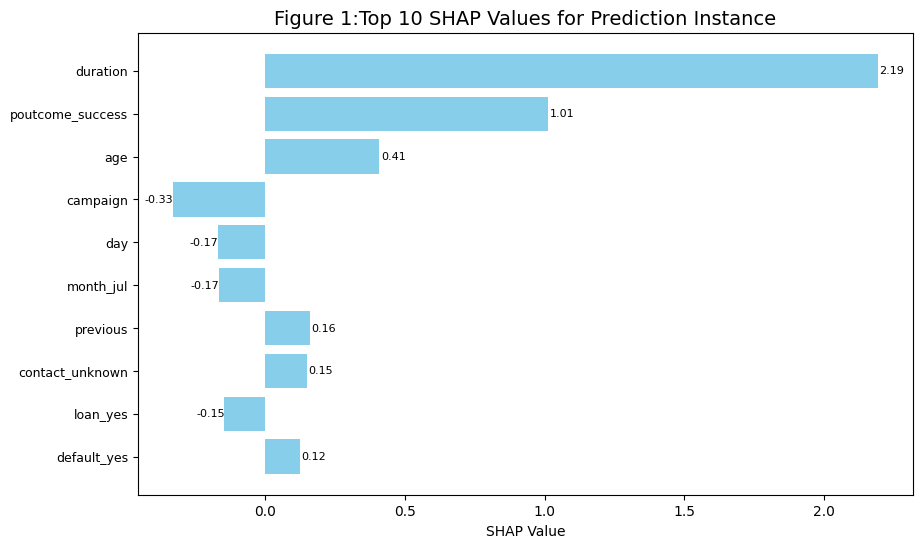

In [11]:
# Create SHAP values visualization plot
shap_values_instance = shap_values[0]
abs_shap_values = np.abs(shap_values_instance)
sorted_indices = np.argsort(abs_shap_values)
top_features_indices = sorted_indices[-10:][::-1]
top_shap_values = shap_values_instance[top_features_indices]
top_feature_names = [feature_names[i] for i in top_features_indices]
plt.figure(figsize=(10, 6))
bars = plt.barh(top_feature_names, top_shap_values, color="skyblue")
for bar, shap_value in zip(bars, top_shap_values):
    if shap_value < 0:
        plt.text(bar.get_x() + bar.get_width() - 0.05, bar.get_y() + bar.get_height() / 2, f'{shap_value:.2f}',
                 ha='center', va='center', fontsize=8)
    else:
        plt.text(bar.get_x() + bar.get_width() + 0.05, bar.get_y() + bar.get_height() / 2, f'{shap_value:.2f}',
                 ha='center', va='center', fontsize=8)
plt.xlabel("SHAP Value")
plt.yticks(fontsize=9)
plt.title("Figure 1:Top 10 SHAP Values for Prediction Instance", fontsize=14)
plt.gca().invert_yaxis()
plt.show()

Both SHAP values and their corresponding visualization plot are being saved for automation purposes in the following section.

In [ ]:
# Save shap_explanations.py file
code = """
import shap
import json
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

# Load XGBOOST model
loaded_model = xgb.XGBClassifier()
loaded_model.load_model("xgb_cv.json")

# Provide SHAP values prediction explanations
features_dict = customer['features']
features_df = pd.DataFrame([features_dict])
explainer = shap.Explainer(loaded_model)
shap_values = explainer.shap_values(features_df)
feature_names = features_df.columns
for i, sample_shap_values in enumerate(shap_values):
    print(f"SHAP values:")
    for feature_name, shap_value in zip(feature_names, sample_shap_values):
        print(f"{feature_name}: {shap_value}")

# Create SHAP values visualization plot
shap_values_instance = shap_values[0]
abs_shap_values = np.abs(shap_values_instance)
sorted_indices = np.argsort(abs_shap_values)
top_features_indices = sorted_indices[-10:][::-1]
top_shap_values = shap_values_instance[top_features_indices]
top_feature_names = [feature_names[i] for i in top_features_indices]
plt.figure(figsize=(10, 6))
bars = plt.barh(top_feature_names, top_shap_values, color="skyblue")
for bar, shap_value in zip(bars, top_shap_values):
    if shap_value < 0:
        plt.text(bar.get_x() + bar.get_width() - 0.05, bar.get_y() + bar.get_height() / 2, f'{shap_value:.2f}',
                 ha='center', va='center', fontsize=8)
    else:
        plt.text(bar.get_x() + bar.get_width() + 0.05, bar.get_y() + bar.get_height() / 2, f'{shap_value:.2f}',
                 ha='center', va='center', fontsize=8)
plt.xlabel("SHAP Value")
plt.yticks(fontsize=9)
plt.title("Figure 1:Top 10 SHAP Values for Prediction Instance", fontsize=14)
plt.gca().invert_yaxis()
plt.show()
"""
with open('shap_explanations.py', 'w') as file:
    file.write(code)
print('Code saved to shap_explanations.py')

It is essential to evaluate whether a feature introduces bias to the model predictions. This assessment is commonly conducted through the Disparate Impact Ratio (DIR), aligned with the regulatory "four-fifths rule" established by the U.S. Equal Employment Opportunity Commission (EEOC).

Ideally, DIR should be equal to one, signifying equal proportions for all groups selected for a specific outcome. However, as per the "four-fifths rule," any DIR value below 80% may indicate "evidence of adverse impact.

Given that DIR is a fraction and the denominator may exceed the numerator, the acceptable DIR range is considered from 80% to 120%. For more details, refer [4].

In the current project, all sensitive variables fall within the acceptable DIR range of 0.8 to 1 is. It's important to note that this test is relevant for binary and categorical variables, excluding numeric features such as age.

In [14]:
# Conduct Bias assessment for each sensitive feature
sensitive_features = ['job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 
'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_secondary', 'education_tertiary', 'education_unknown', 'marital_married',
'marital_single']
def calculate_disparate_impact(y_true, y_pred):
    non_sensitive_indices = ~y_true.astype(bool)
    positive_proportion_sensitive = y_pred.mean()
    positive_proportion_non_sensitive = y_pred[non_sensitive_indices].mean()
    if positive_proportion_sensitive == 0:
        return float('nan')
    disparate_impact = positive_proportion_non_sensitive / positive_proportion_sensitive
    return disparate_impact
for sensitive_feature in sensitive_features:
    y_true_sensitive = X_test[sensitive_feature].astype(float)
    y_pred_sensitive = y_test_pred
    disparate_impact = calculate_disparate_impact(y_true_sensitive, y_pred_sensitive)
    print(f"Disparate Impact Ratio for {sensitive_feature}: {disparate_impact}")

Disparate Impact Ratio for job_blue-collar: 1.1009374615656087
Disparate Impact Ratio for job_entrepreneur: 1.0075925362113747
Disparate Impact Ratio for job_housemaid: 1.0039878946663987
Disparate Impact Ratio for job_management: 0.9603016827951932
Disparate Impact Ratio for job_retired: 0.9352061432309978
Disparate Impact Ratio for job_self-employed: 0.9983608879824595
Disparate Impact Ratio for job_services: 1.02602072483231
Disparate Impact Ratio for job_student: 0.9703227968968453
Disparate Impact Ratio for job_technician: 1.0145022246546065
Disparate Impact Ratio for job_unemployed: 0.9935373021395573
Disparate Impact Ratio for job_unknown: 0.9996288209392018
Disparate Impact Ratio for education_secondary: 1.1089361574268015
Disparate Impact Ratio for education_tertiary: 0.9030301151867772
Disparate Impact Ratio for education_unknown: 0.9849862934117605
Disparate Impact Ratio for marital_married: 1.1579462719062659
Disparate Impact Ratio for marital_single: 0.9083573808415037


The bias assessment was saved as a Python file with the intention of automating in the corresponding section.

In [ ]:
# Save bias_assessment.py file
code = """
import json
import numpy as np
import xgboost as xgb

# Load XGBOOST model
loaded_model = xgb.XGBClassifier()
loaded_model.load_model("xgb_cv.json")

# Conduct Bias assessment for each sensitive feature
sensitive_features = ['job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 
'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_secondary', 'education_tertiary', 'education_unknown', 'marital_married',
'marital_single']

def calculate_disparate_impact(y_true, y_pred):
    non_sensitive_indices = ~y_true.astype(bool)
    positive_proportion_sensitive = y_pred.mean()
    positive_proportion_non_sensitive = y_pred[non_sensitive_indices].mean()
    if positive_proportion_sensitive == 0:
        return float('nan')
    disparate_impact = positive_proportion_non_sensitive / positive_proportion_sensitive
    return disparate_impact

for sensitive_feature in sensitive_features:
    y_true_sensitive = X_test[sensitive_feature].astype(float)
    y_pred_sensitive = y_test_pred
    disparate_impact = calculate_disparate_impact(y_true_sensitive, y_pred_sensitive)
    print(f"Disparate Impact Ratio for {sensitive_feature}: {disparate_impact}")
"""
with open('bias_assessment.py', 'w') as file:
    file.write(code)
print('Code saved to bias_assessment.py')

Employing unit tests becomes crucial to systematically assess different components of the application in isolation. This proactive approach helps to detect any potential issues before the application advances to production.

Fortunately, the results of the tests indicate that everything is functioning as expected within the application.

In [15]:
# Conduct unit testing
def predict(features, model):
    prediction = model.predict(np.array([list(features.values())]))
    binary_prediction = np.round(prediction)
    return int(binary_prediction[0])
class TestModel(unittest.TestCase):
    def test_predict(self):
        features = {
            'age': 18,
            'balance': 300,
            'day': 5,
            'duration': 500,
            'campaign': 1,
            'pdays': -1,
            'previous': 4,
            'job_blue-collar': 0,
            'job_entrepreneur': 0,
            'job_housemaid': 0,
            'job_management': 1,
            'job_retired': 0,
            'job_self-employed': 0,
            'job_services': 0,
            'job_student': 0,
            'job_technician': 0,
            'job_unemployed': 0,
            'job_unknown': 0,
            'education_secondary': 1,
            'education_tertiary': 0,
            'education_unknown': 0,
            'marital_married': 1,
            'marital_single': 0,
            'default_yes': 0,
            'housing_yes': 1,
            'loan_yes': 0,
            'contact_telephone': 1,
            'contact_unknown': 0,
            'month_aug': 0,
            'month_dec': 0,
            'month_feb': 0,
            'month_jan': 0,
            'month_jul': 1,
            'month_jun': 0,
            'month_mar': 0,
            'month_may': 0,
            'month_nov': 0,
            'month_oct': 0,
            'month_sep': 0,
            'poutcome_other': 0,
            'poutcome_success': 0,
            'poutcome_unknown': 1
        }
        prediction = predict(features, loaded_model)
        self.assertIn(prediction, [0, 1])
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestModel))

.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

This unit test python file is intended for use within the source code, particularly when automated in subsequent section.

In [ ]:
# Save unit_testing.py file
code = """
import json
import unittest
import numpy as np
import xgboost as xgb

# Load XGBOOST model
loaded_model = xgb.XGBClassifier()
loaded_model.load_model("xgb_cv.json")

# Conduct unit testing
def predict(features, model):
    prediction = model.predict(np.array([list(features.values())]))
    binary_prediction = np.round(prediction)
    return int(binary_prediction[0])

class TestModel(unittest.TestCase):
    def test_predict(self):
        features = {
            'age': 18,
            'balance': 300,
            'day': 5,
            'duration': 500,
            'campaign': 1,
            'pdays': -1,
            'previous': 4,
            'job_blue-collar': 0,
            'job_entrepreneur': 0,
            'job_housemaid': 0,
            'job_management': 1,
            'job_retired': 0,
            'job_self-employed': 0,
            'job_services': 0,
            'job_student': 0,
            'job_technician': 0,
            'job_unemployed': 0,
            'job_unknown': 0,
            'education_secondary': 1,
            'education_tertiary': 0,
            'education_unknown': 0,
            'marital_married': 1,
            'marital_single': 0,
            'default_yes': 0,
            'housing_yes': 1,
            'loan_yes': 0,
            'contact_telephone': 1,
            'contact_unknown': 0,
            'month_aug': 0,
            'month_dec': 0,
            'month_feb': 0,
            'month_jan': 0,
            'month_jul': 1,
            'month_jun': 0,
            'month_mar': 0,
            'month_may': 0,
            'month_nov': 0,
            'month_oct': 0,
            'month_sep': 0,
            'poutcome_other': 0,
            'poutcome_success': 0,
            'poutcome_unknown': 1
        }
        prediction = predict(features, loaded_model)
        self.assertIn(prediction, [0, 1])

unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestModel))
"""
with open('unit_testing.py', 'w') as file:
    file.write(code)
print('Code saved to unit_testing.py')

Another crucial end-to-end test for the ML project has been successfully completed. This comprehensive test evaluates the application as a unified entity, ensuring that all components work seamlessly together.

The  results were error-free, indicating the robustness and coherence of the entire application.

In [16]:
# Conduct end-to-end-test
class TestEndToEnd(unittest.TestCase):
    def test_end_to_end(self):
        features = {
            'age': 18,
            'balance': 300,
            'day': 5,
            'duration': 500,
            'campaign': 1,
            'pdays': -1,
            'previous': 4,
            'job_blue-collar': 0,
            'job_entrepreneur': 0,
            'job_housemaid': 0,
            'job_management': 1,
            'job_retired': 0,
            'job_self-employed': 0,
            'job_services': 0,
            'job_student': 0,
            'job_technician': 0,
            'job_unemployed': 0,
            'job_unknown': 0,
            'education_secondary': 1,
            'education_tertiary': 0,
            'education_unknown': 0,
            'marital_married': 1,
            'marital_single': 0,
            'default_yes': 0,
            'housing_yes': 1,
            'loan_yes': 0,
            'contact_telephone': 1,
            'contact_unknown': 0,
            'month_aug': 0,
            'month_dec': 0,
            'month_feb': 0,
            'month_jan': 0,
            'month_jul': 1,
            'month_jun': 0,
            'month_mar': 0,
            'month_may': 0,
            'month_nov': 0,
            'month_oct': 0,
            'month_sep': 0,
            'poutcome_other': 0,
            'poutcome_success': 0,
            'poutcome_unknown': 1
        }
        endpoint = "http://localhost:8081/predict"
        response = requests.post(endpoint, json={'features': features})
        self.assertEqual(response.status_code, 200)
        print("Response content:", response.content)
        response_json = response.json()
        print("Response JSON:", response_json)
        prediction = response_json.get('prediction', None)
        self.assertIsNotNone(prediction)
        self.assertGreaterEqual(prediction, 0.0)
        self.assertLessEqual(prediction, 1.0)
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestEndToEnd))

.
----------------------------------------------------------------------
Ran 1 test in 0.014s

OK


Response content: b'{"prediction":0.6571007966995239}\n'
Response JSON: {'prediction': 0.6571007966995239}


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

A Python file was created to perform an end-to-end test, with the goal of automating its execution in the upcoming section.

In [ ]:
# Save end_to_end_test.py file
code = """
import json
import unittest
import requests
import numpy as np
import xgboost as xgb

# Load XGBOOST model
loaded_model = xgb.XGBClassifier()
loaded_model.load_model("xgb_cv.json")

# Conduct end-to-end-test
class TestEndToEnd(unittest.TestCase):
    def test_end_to_end(self):
        features = {
            'age': 18,
            'balance': 300,
            'day': 5,
            'duration': 500,
            'campaign': 1,
            'pdays': -1,
            'previous': 4,
            'job_blue-collar': 0,
            'job_entrepreneur': 0,
            'job_housemaid': 0,
            'job_management': 1,
            'job_retired': 0,
            'job_self-employed': 0,
            'job_services': 0,
            'job_student': 0,
            'job_technician': 0,
            'job_unemployed': 0,
            'job_unknown': 0,
            'education_secondary': 1,
            'education_tertiary': 0,
            'education_unknown': 0,
            'marital_married': 1,
            'marital_single': 0,
            'default_yes': 0,
            'housing_yes': 1,
            'loan_yes': 0,
            'contact_telephone': 1,
            'contact_unknown': 0,
            'month_aug': 0,
            'month_dec': 0,
            'month_feb': 0,
            'month_jan': 0,
            'month_jul': 1,
            'month_jun': 0,
            'month_mar': 0,
            'month_may': 0,
            'month_nov': 0,
            'month_oct': 0,
            'month_sep': 0,
            'poutcome_other': 0,
            'poutcome_success': 0,
            'poutcome_unknown': 1
        }
        endpoint = "http://flask-api-service/predict"
        response = requests.post(endpoint, json={'features': features})
        self.assertEqual(response.status_code, 200)
        print("Response content:", response.content)
        response_json = response.json()
        print("Response JSON:", response_json)
        prediction = response_json.get('prediction', None)
        self.assertIsNotNone(prediction)
        self.assertGreaterEqual(prediction, 0.0)
        self.assertLessEqual(prediction, 1.0)
        
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestEndToEnd))
"""
with open('end_to_end_test.py', 'w') as file:
    file.write(code)
print('Code saved to end_to_end_test.py')


The decision to showcase the Depositer application in Streamlit was driven by its simplicity and seamless integration with Python, making the configuration process remarkably straightforward.

Depositer has undergone thorough testing within the local environment. As a result, it demonstrates reliable functionality and meets expectations for smooth operation.

In [21]:
# Create Depositer application in Streamlit
loaded_model = xgb.XGBClassifier()
loaded_model.load_model("xgb_cv.json")

st.title('Depositer')
st.write("Predict deposit subscriptions")

def user_input_features():
    age = st.slider('Age (in years)', 18, 130, 18)
    balance = st.slider('Balance (in EUR)', -10000000, 10000000, 0)
    day = st.slider('Last Contact Day of the Month', 1, 31, 1)
    duration = st.slider('Duration of Last Contact (in seconds)', 0, 10000, 0)
    campaign = st.slider('Number of Contacts Performed During This Campaign', 1, 1000, 1)
    pdays = st.slider('Number of Days Passed After the Client Was Last Contacted (-1 means not previously contacted)', -1, 1000, -1)
    previous = st.slider('Number of Contacts Performed Before This Campaign', 0, 1000, 0)

    job = ['Blue-Collar', 'Entrepreneur', 'Housemaid', 'Management', 'Retired', 'Self-employed',
           'Services', 'Student', 'Technician', 'Unemployed', 'Unknown']
    job_selected = st.selectbox("Job Type", job)
    job_category = {f'job_{category.lower()}': 1 if category == job_selected else 0 for category in job}
    
    education = ['Secondary', 'Tertiary', 'Unknown']
    education_selected = st.selectbox("Education Level", education)
    education_category = {f'education_{category.lower()}': 1 if category == education_selected else 0 for category in education}

    marital = ['Married', 'Single']
    marital_selected = st.selectbox("Marital Status", marital)
    marital_category = {f'marital_{category.lower()}': 1 if category == marital_selected else 0 for category in marital}

    contact =  ['Telephone', 'Unknown']
    contact_selected = st.selectbox("Contact Communication Type", contact)
    contact_category = {f'contact_{category.lower()}': 1 if category == contact_selected else 0 for category in contact}

    month = ['January', 'February', 'March', 'May', 'June', 'July', 'August','September', 'October', 'November', 'December']
    month_selected = st.selectbox('Contact Month', month)
    month_category = {f'month_{category.lower()}': 1 if category == month_selected else 0 for category in month}
    
    poutcome = ['Success', 'Other', 'Unknown']
    poutcome_selected = st.selectbox('Previous Campaign Outcome', poutcome)
    poutcome_category = {f'poutcome_{category.lower()}': 1 if category == poutcome_selected else 0 for category in poutcome}

    default_yes = st.checkbox('Credit Default (Yes)')
    housing_yes = st.checkbox('Housing Loan (Yes)')
    loan_yes = st.checkbox('Personal Loan (Yes)')
    
    user_features = {
        'age': age,
        'balance': balance,
        'day': day,
        'duration': duration,
        'campaign': campaign,
        'pdays': pdays,
        'previous': previous,
        'job_blue-collar': job_category,
        'job_entrepreneur': job_category,
        'job_housemaid': job_category,
        'job_management': job_category,
        'job_retired': job_category,
        'job_self-employed': job_category,
        'job_services': job_category,
        'job_student': job_category,
        'job_technician': job_category,
        'job_unemployed': job_category,
        'job_unknown': job_category,
        'education_secondary': education_category,
        'education_tertiary': education_category,
        'education_unknown': education_category,
        'marital_married': marital_category,
        'marital_single': marital_category,
        'contact_telephone': contact_category,
        'contact_unknown': contact_category,
        'month_aug': month_category,
        'month_dec': month_category,
        'month_feb': month_category,
        'month_jan': month_category,
        'month_jul': month_category,
        'month_jun': month_category,
        'month_mar': month_category,
        'month_may': month_category,
        'month_nov': month_category,
        'month_oct': month_category,
        'month_sep': month_category,
        'poutcome_other': poutcome_category,
        'poutcome_success': poutcome_category,
        'poutcome_unknown': poutcome_category,
        'default_yes': default_yes,
        'housing_yes': housing_yes,
        'loan_yes': loan_yes
    }
    return user_features

user_features = user_input_features()
if st.button('Predict'):
    flattened_features = {}
    for key, value in user_features.items():
        if isinstance(value, dict):
            flattened_features.update(value)
        else:
            flattened_features[key] = value
    url = "http://localhost:8081/predict"
    headers = {'Content-Type': 'application/json'}
    response = requests.post(url, json={'features': flattened_features}, headers=headers)
    if response and response.status_code == 200:
        prediction = response.json().get('prediction', None)
        st.success(f'Deposit Subscription Probability: {prediction:.2f}')
    elif response:
        st.error("Failed to get prediction from the server.")

The Python file containing the Streamlit application was saved to enable automation in the following section.

In [ ]:
# Save streamlit.py file
code = """
import json
import requests
import xgboost as xgb
import streamlit as st

# Create Depositer application in Streamlit
loaded_model = xgb.XGBClassifier()
loaded_model.load_model("xgb_cv.json")

st.title('Depositer')
st.write("Predict deposit subscriptions")

def user_input_features():
    age = st.slider('Age (in years)', 18, 130, 18)
    balance = st.slider('Balance (in EUR)', -10000000, 10000000, 0)
    day = st.slider('Last Contact Day of the Month', 1, 31, 1)
    duration = st.slider('Duration of Last Contact (in seconds)', 0, 10000, 0)
    campaign = st.slider('Number of Contacts Performed During This Campaign', 1, 1000, 1)
    pdays = st.slider('Number of Days Passed After the Client Was Last Contacted (-1 means not previously contacted)', -1, 1000, -1)
    previous = st.slider('Number of Contacts Performed Before This Campaign', 0, 1000, 0)

    job = ['Blue-Collar', 'Entrepreneur', 'Housemaid', 'Management', 'Retired', 'Self-employed',
           'Services', 'Student', 'Technician', 'Unemployed', 'Unknown']
    job_selected = st.selectbox("Job Type", job)
    job_category = {f'job_{category.lower()}': 1 if category == job_selected else 0 for category in job}
    
    education = ['Secondary', 'Tertiary', 'Unknown']
    education_selected = st.selectbox("Education Level", education)
    education_category = {f'education_{category.lower()}': 1 if category == education_selected else 0 for category in education}

    marital = ['Married', 'Single']
    marital_selected = st.selectbox("Marital Status", marital)
    marital_category = {f'marital_{category.lower()}': 1 if category == marital_selected else 0 for category in marital}

    contact =  ['Telephone', 'Unknown']
    contact_selected = st.selectbox("Contact Communication Type", contact)
    contact_category = {f'contact_{category.lower()}': 1 if category == contact_selected else 0 for category in contact}

    month = ['January', 'February', 'March', 'May', 'June', 'July', 'August','September', 'October', 'November', 'December']
    month_selected = st.selectbox('Contact Month', month)
    month_category = {f'month_{category.lower()}': 1 if category == month_selected else 0 for category in month}
    
    poutcome = ['Success', 'Other', 'Unknown']
    poutcome_selected = st.selectbox('Previous Campaign Outcome', poutcome)
    poutcome_category = {f'poutcome_{category.lower()}': 1 if category == poutcome_selected else 0 for category in poutcome}

    default_yes = st.checkbox('Credit Default (Yes)')
    housing_yes = st.checkbox('Housing Loan (Yes)')
    loan_yes = st.checkbox('Personal Loan (Yes)')
    
    user_features = {
        'age': age,
        'balance': balance,
        'day': day,
        'duration': duration,
        'campaign': campaign,
        'pdays': pdays,
        'previous': previous,
        'job_blue-collar': job_category,
        'job_entrepreneur': job_category,
        'job_housemaid': job_category,
        'job_management': job_category,
        'job_retired': job_category,
        'job_self-employed': job_category,
        'job_services': job_category,
        'job_student': job_category,
        'job_technician': job_category,
        'job_unemployed': job_category,
        'job_unknown': job_category,
        'education_secondary': education_category,
        'education_tertiary': education_category,
        'education_unknown': education_category,
        'marital_married': marital_category,
        'marital_single': marital_category,
        'contact_telephone': contact_category,
        'contact_unknown': contact_category,
        'month_aug': month_category,
        'month_dec': month_category,
        'month_feb': month_category,
        'month_jan': month_category,
        'month_jul': month_category,
        'month_jun': month_category,
        'month_mar': month_category,
        'month_may': month_category,
        'month_nov': month_category,
        'month_oct': month_category,
        'month_sep': month_category,
        'poutcome_other': poutcome_category,
        'poutcome_success': poutcome_category,
        'poutcome_unknown': poutcome_category,
        'default_yes': default_yes,
        'housing_yes': housing_yes,
        'loan_yes': loan_yes
    }
    return user_features

user_features = user_input_features()
if st.button('Predict'):
    flattened_features = {}
    for key, value in user_features.items():
        if isinstance(value, dict):
            flattened_features.update(value)
        else:
            flattened_features[key] = value
    url = "http://localhost:8081/predict"
    headers = {'Content-Type': 'application/json'}
    response = requests.post(url, json={'features': flattened_features}, headers=headers)
    if response and response.status_code == 200:
        prediction = response.json().get('prediction', None)
        st.success(f'Deposit Subscription Probability: {prediction:.2f}')
    elif response:
        st.error("Failed to get prediction from the server.")
"""
with open('streamlit.py', 'w') as file:
    file.write(code)
print('Code saved to streamlit.py')


Streamlit was tested in a virtual Pipenv environment to mitigate potential dependency conflicts. It ran smoothly without encountering any issues.

In [ ]:
# [Code in progress]

# Create streamlit virtual pipenv environment
pipenv install streamlit --dev
pipenv shell

## Staging environment

The project advances to the staging environment, a pre-production environment designated for thorough testing before implementing changes in the live production. This environment is tailored for testing and containerizing both server and client components to ensure they function optimally in production settings.

In the preceding subsection, the Flask server underwent testing within the local environment. While it performed adequately under local conditions, it lacks the robustness necessary for production deployment, as it may not effectively handle the varied challenges inherent in production environments. Consequently, to ensure a more reliable production setup, the Gunicorn server, an extension of Flask, was deployed within a Python file.

In [ ]:
# [Code in progress]

# Save gunicorn.py file
code = """
import json
import numpy as np
import xgboost as xgb
from flask import Flask, request, jsonify

# Create Flask application
loaded_model = xgb.XGBClassifier()
loaded_model.load_model("xgb_cv.json")

expected_number_of_features = 42
def predict_single(features, model):
    feature_names = model.get_booster().feature_names
    features = [features.get(feature, 0) for feature in feature_names]
    X = np.array(features).reshape(1, -1)
    prediction = loaded_model.predict_proba(X)
    return float(prediction[0, 1])
application = Flask(__name__)
@application.route('/predict', methods=['POST','GET'])
def predict():
    try:
        if request.method == 'POST':
            data = request.get_json(force=True)
            features = data.get('features', {})
        else:
            features = request.args.get('features')
            features = json.loads(features) if features else {}
        if len(features) != expected_number_of_features:
            return jsonify({'error': 'Invalid number of features'}), 400
        prediction = predict_single(features, loaded_model)
        return jsonify({'prediction': prediction})
    except Exception as e:
        return jsonify({'error': str(e)}), 500
if __name__ == '__main__':
    application.run(host='0.0.0.0', port=8081)
"""
with open('gunicorn.py', 'w') as file:
    file.write(code)
print('Code saved to gunicorn.py')

The Gunicorn server was tested within the Pipenv virtual environment, and no issues were encountered.

In [ ]:
# [Code in progress]

# Create gunicorn virtual pipenv environment
pipenv install gunicorn
pipenv shell

The Streamlit application, which was tested in the local environment, remains largely unchanged, with the exception of configuring the prediction URL for the Gunicorn API server. This adjustment allows Streamlit to gather machine learning predictions in the production environment.

In [ ]:
# Save streamlit_app.py file
code = """
import json
import requests
import xgboost as xgb
import streamlit as st

# Create Depositer application in Streamlit
loaded_model = xgb.XGBClassifier()
loaded_model.load_model("xgb_cv.json")

st.title('Depositer')
st.write("Predict deposit subscriptions")

def user_input_features():
    age = st.slider('Age (in years)', 18, 130, 18)
    balance = st.slider('Balance (in EUR)', -10000000, 10000000, 0)
    day = st.slider('Last Contact Day of the Month', 1, 31, 1)
    duration = st.slider('Duration of Last Contact (in seconds)', 0, 10000, 0)
    campaign = st.slider('Number of Contacts Performed During This Campaign', 1, 1000, 1)
    pdays = st.slider('Number of Days Passed After the Client Was Last Contacted (-1 means not previously contacted)', -1, 1000, -1)
    previous = st.slider('Number of Contacts Performed Before This Campaign', 0, 1000, 0)

    job = ['Blue-Collar', 'Entrepreneur', 'Housemaid', 'Management', 'Retired', 'Self-employed',
           'Services', 'Student', 'Technician', 'Unemployed', 'Unknown']
    job_selected = st.selectbox("Job Type", job)
    job_category = {f'job_{category.lower()}': 1 if category == job_selected else 0 for category in job}
    
    education = ['Secondary', 'Tertiary', 'Unknown']
    education_selected = st.selectbox("Education Level", education)
    education_category = {f'education_{category.lower()}': 1 if category == education_selected else 0 for category in education}

    marital = ['Married', 'Single']
    marital_selected = st.selectbox("Marital Status", marital)
    marital_category = {f'marital_{category.lower()}': 1 if category == marital_selected else 0 for category in marital}

    contact =  ['Telephone', 'Unknown']
    contact_selected = st.selectbox("Contact Communication Type", contact)
    contact_category = {f'contact_{category.lower()}': 1 if category == contact_selected else 0 for category in contact}

    month = ['January', 'February', 'March', 'May', 'June', 'July', 'August','September', 'October', 'November', 'December']
    month_selected = st.selectbox('Contact Month', month)
    month_category = {f'month_{category.lower()}': 1 if category == month_selected else 0 for category in month}
    
    poutcome = ['Success', 'Other', 'Unknown']
    poutcome_selected = st.selectbox('Previous Campaign Outcome', poutcome)
    poutcome_category = {f'poutcome_{category.lower()}': 1 if category == poutcome_selected else 0 for category in poutcome}

    default_yes = st.checkbox('Credit Default (Yes)')
    housing_yes = st.checkbox('Housing Loan (Yes)')
    loan_yes = st.checkbox('Personal Loan (Yes)')
    
    user_features = {
        'age': age,
        'balance': balance,
        'day': day,
        'duration': duration,
        'campaign': campaign,
        'pdays': pdays,
        'previous': previous,
        'job_blue-collar': job_category,
        'job_entrepreneur': job_category,
        'job_housemaid': job_category,
        'job_management': job_category,
        'job_retired': job_category,
        'job_self-employed': job_category,
        'job_services': job_category,
        'job_student': job_category,
        'job_technician': job_category,
        'job_unemployed': job_category,
        'job_unknown': job_category,
        'education_secondary': education_category,
        'education_tertiary': education_category,
        'education_unknown': education_category,
        'marital_married': marital_category,
        'marital_single': marital_category,
        'contact_telephone': contact_category,
        'contact_unknown': contact_category,
        'month_aug': month_category,
        'month_dec': month_category,
        'month_feb': month_category,
        'month_jan': month_category,
        'month_jul': month_category,
        'month_jun': month_category,
        'month_mar': month_category,
        'month_may': month_category,
        'month_nov': month_category,
        'month_oct': month_category,
        'month_sep': month_category,
        'poutcome_other': poutcome_category,
        'poutcome_success': poutcome_category,
        'poutcome_unknown': poutcome_category,
        'default_yes': default_yes,
        'housing_yes': housing_yes,
        'loan_yes': loan_yes
    }
    return user_features

user_features = user_input_features()
if st.button('Predict'):
    flattened_features = {}
    for key, value in user_features.items():
        if isinstance(value, dict):
            flattened_features.update(value)
        else:
            flattened_features[key] = value
    url = "http://gunicorn-api-service/predict"
    headers = {'Content-Type': 'application/json'}
    response = requests.post(url, json={'features': flattened_features}, headers=headers)
    if response and response.status_code == 200:
        prediction = response.json().get('prediction', None)
        st.success(f'Deposit Subscription Probability: {prediction:.2f}')
    elif response:
        st.error("Failed to get prediction from the server.")
"""
with open('streamlit_app.py', 'w') as file:
    file.write(code)
print('Code saved to streamlit_app.py')

Streamlit was tested in a virtual Pipenv environment to mitigate potential dependency conflicts. It ran smoothly without encountering any issues.

In [ ]:
# [Code in progress]

# Create streamlit virtual pipenv environment
pipenv install streamlit
pipenv shell

The integration test was designed to verify the compatibility between the Gunicorn API server and the Streamlit app. It passed without any drawbacks.

In [ ]:
# [Code in progress]

import unittest
import requests

# Conduct integration test
class TestIntegration(unittest.TestCase):
    def test_model_integration(self):
        # Mock features to send to the model service
        features = {
            'age': 18,
            'balance': 300,
            'day': 5,
            'duration': 500,
            'campaign': 1,
            'pdays': -1,
            'previous': 4,
            'job_blue-collar': 0,
            'job_entrepreneur': 0,
            'job_housemaid': 0,
            'job_management': 1,
            'job_retired': 0,
            'job_self-employed': 0,
            'job_services': 0,
            'job_student': 0,
            'job_technician': 0,
            'job_unemployed': 0,
            'job_unknown': 0,
            'education_secondary': 1,
            'education_tertiary': 0,
            'education_unknown': 0,
            'marital_married': 1,
            'marital_single': 0,
            'default_yes': 0,
            'housing_yes': 1,
            'loan_yes': 0,
            'contact_telephone': 1,
            'contact_unknown': 0,
            'month_aug': 0,
            'month_dec': 0,
            'month_feb': 0,
            'month_jan': 0,
            'month_jul': 1,
            'month_jun': 0,
            'month_mar': 0,
            'month_may': 0,
            'month_nov': 0,
            'month_oct': 0,
            'month_sep': 0,
            'poutcome_other': 0,
            'poutcome_success': 0,
            'poutcome_unknown': 1
        }
        
        # Send a request to the model service
        endpoint = "http://localhost:8081/predict"
        response = requests.post(endpoint, json={'features': features})
        
        # Check if the response is successful
        self.assertEqual(response.status_code, 200)
        
        # Check if the prediction is within a valid range
        response_json = response.json()
        prediction = response_json.get('prediction', None)
        self.assertIsNotNone(prediction)
        self.assertGreaterEqual(prediction, 0.0)
        self.assertLessEqual(prediction, 1.0)

# Run the integration test
if __name__ == "__main__":
    unittest.main()

Docker, being a contemporary containerization solution, is employed to isolate environment-related issues of both the server and client applications.

The Dockerfile configuration for the Gunicorn API server was created using a notepad.

In [ ]:
# [Code in progress]

# Create Dockerfile for gunicorn api
FROM python:3.8-slim
WORKDIR /app
COPY flask_api /app
RUN pip install --no-cache-dir -r requirements.txt
EXPOSE 8081
CMD ["python", "app.py"]

COPY ../xgb_cv.json .
RUN pipenv

A Docker container is established for the Gunicorn API, ensuring dependency isolation for the ML application.

In [ ]:
# [Code in progress]

# Create flask api docker container
cd C:\Users\Alexander_Kalita\my_mlops_project
docker build -t xgb_cv_image -f flask_api\Dockerfile .
docker run -it --name xgb_cv_container -p 8081:8081 xgb_cv_image

The Dockerfile for the Streamlit application was configured using a notepad.

In [ ]:
# Create Dockerfile for streamlit app
FROM python:3.8-slim
WORKDIR /app
COPY streamlit_app /app
RUN pip install --no-cache-dir -r requirements.txt
CMD ["streamlit", "run", "streamlit_app.py"]

COPY ../xgb_cv.json .
RUN pipenv

The Streamlit application was containerized using Docker.

In [ ]:
# Create streamlit docker container
cd C:\Users\Alexander_Kalita\my_mlops_project
docker build -t xgb_cv_streamlit_image -f streamlit_app\Dockerfile .
docker run -it --name xgb_cv_streamlit_container -p 8501:8501 xgb_cv_streamlit_image

The Docker Compose file was created to facilitate communication between the Depositer client application in Streamlit and the Gunicorn API server.

In [ ]:
# [Code in progress]

# Save docker-compose.yaml file
code = """
version: '3.8'

services:
  flask-api:
    build:
      context: ./flask_api
    ports:
      - "8081:8081"
    depends_on:
      - streamlit-app

  streamlit-app:
    build:
      context: ./streamlit_app
    ports:
      - "8501:8501"
    depends_on:
      - flask-api
"""
with open('docker-compose.yaml', 'w') as file:
    file.write(code)
print('Code saved to docker-compose.yaml')

Docker containers were successfully built, ensuring that both the server and client function as expected in the local environment.

In [ ]:
# Build and start the containers
cd C:\Users\Alexander_Kalita\my_mlops_project
docker-compose up -d

The Docker containers were deployed to Docker Hub, a widely recognized online repository for container images. Utilizing Docker Hub allows for seamless sharing and distribution of containerized applications.

In [ ]:
# [Code in progress]

# Deploy Docker containers on Docker Hub
docker login
cd C:\Users\Alexander_Kalita\my_mlops_project

docker build -t alexanderkalita/depositer:xgb_cv_tag -f flask_api\Dockerfile .
docker push alexanderkalita/depositer:xgb_cv_tag

docker build -t alexanderkalita/depositer:xgb_cv_streamlit_tag -f streamlit_app\Dockerfile .
docker push alexanderkalita/depositer:xgb_cv_streamlit_tag

## Production environment

The production environment utilizes a variety of tools orchestrated within the Elastic Kubernetes Service (EKS) on the Amazon Web Services (AWS) cloud.

Terraform is used as a solution for storing and dynamically managing a variety of cloud configurations. This capability is vital as it eliminates the need for manual updates of AWS services.

In [ ]:
# [Code in progress]

# Terraform configuration for automation

provider "aws" {
    profile = "arn: aws: iam:: <my account>: instance
    profile = "<my role name>"
    region = var.aws_region
}


The Depositer application is deployed in production using EKS, a top-tier cloud service provided by AWS. This container orchestration platform plays a crucial role in hosting the application online effectively.

In [ ]:
# Create EKS in AWS
cd C:\Users\Alexander_Kalita\my_mlops_project
pip install awscli
aws --version
aws configure

kubectl version --short --client
choco install -y eksctl
eksctl version

eksctl create cluster --name depositer-cluster --region eu-north-1 --nodegroup-name depositer-nodes --node-type t3.small --nodes 2

eksctl delete cluster --name depositer-cluster

Traefik is a cutting-edge reverse proxy and load balancer, playing a key role in directing traffic from the internet to the project's microservice architecture on EKS. Its advanced features ensure efficient routing and distribution of requests within the system.

It was configured with an AWS load balancer to manage external traffic and utilize AWS Certificate Manager (ACM) for HTTPS secured connections within the EKS cluster. The web domain 'depositer.click' was acquired from AWS for this project.

In [1]:
# Save traefik.yaml file
code = """
replicas: 1
rbac:
  enabled: true
logs:
  general:
    level: INFO
  access:
    enabled: false
ingressRoute:
  dashboard:
    enabled: true
service:
  annotations:
    external-dns.alpha.kubernetes.io/hostname: traefik.depositer.click
    service.beta.kubernetes.io/aws-load-balancer-type: nlb
    service.beta.kubernetes.io/aws-load-balancer-nlb-target-type: ip
    service.beta.kubernetes.io/aws-load-balancer-scheme: internet-facing
    service.beta.kubernetes.io/aws-load-balancer-ssl-cert: arn:aws:acm:eu-north-1:623897556329:certificate/1437db38-eb7f-4943-90b1-a180a0ad44e6
    service.beta.kubernetes.io/aws-load-balancer-ssl-negotiation-policy: ELBSecurityPolicy-TLS-1-2-2017-01
    service.beta.kubernetes.io/aws-load-balancer-ssl-ports: "443, 9000"
    service.beta.kubernetes.io/load-balancer-source-ranges: 0.0.0.0/0
globalArguments:
  - "--api.insecure=false"
ports:
  web:
    port: 8080
    expose: true
    exposedPort: 80
    protocol: TCP
    tls:
      enabled: false
  websecure:
    port: 8443
    expose: true
    exposedPort: 443
    protocol: TCP
    tls:
      enabled: true
  traefik:
    port: 9000
    expose: true
    exposedPort: 9000
    protocol: TCP
    tls:
      enabled: true
"""
with open('traefik.yaml', 'w') as file:
    file.write(code)
print('Code saved to traefik.yaml')

Code saved to traefik.yaml


In the project, Helm serves as an automated package management tool, significantly simplifying the setup of Traefik within the kubernetes. It is then deployed to EKS.

In [ ]:
# Install traefik with helm
helm repo add traefik https://helm.traefik.io/traefik
helm repo update

cd C:\Users\Alexander_Kalita\my_mlops_project\kubernetes
helm install traefik traefik/traefik -f traefik.yaml -n default

helm uninstall traefik

As a valuable addition, Traefik offers a comprehensive monitoring dashboard that efficiently tracks its configuration in real-time. This dashboard provides visualization for rapid troubleshooting of occuring errors.

In [2]:
# Save traefik_dashboard.yaml file
code = """
apiVersion: v1
kind: Secret
metadata:
  name: traefik-dashboard-auth-secret
type: kubernetes.io/basic-auth
stringData:
  username: admin
  password: admin

---
apiVersion: traefik.io/v1alpha1
kind: Middleware
metadata:
  name: traefik-dashboard-auth
  namespace: default
spec:
  basicAuth:
    secret: traefik-dashboard-auth-secret

---
apiVersion: traefik.io/v1alpha1
kind: IngressRoute
metadata:
  name: traefik-dashboard
  namespace: default
spec:
  entryPoints:
    - websecure
  routes:
    - kind: Rule
      match: Host(`traefik.depositer.click`) && PathPrefix(`/dashboard`)
      services:
        - kind: TraefikService
          name: api@internal
      middlewares:
        - name: traefik-dashboard-auth
  tls: {} 
"""
with open('traefik_dashboard.yaml', 'w') as file:
    file.write(code)
print('Code saved to traefik_dashboard.yaml')

Code saved to traefik_dashboard.yaml


The Traefik dashboard is forwarded to the local computer, enhancing monitoring accessibility and efficiency.

In [ ]:
# Create traefik dashboard in the local environment
kubectl port-forward $(kubectl get pods --selector "app.kubernetes.io/name=traefik" --output=name) 9000:9000

kubectl port-forward $(kubectl get pods -l "app.kubernetes.io/name=traefik" -o=name) 9000:9000

kubectl get pods -l "app.kubernetes.io/name=traefik" -o=name
kubectl port-forward traefik-69bb7448db-bxbrw 9000:9000

http://localhost:9000

https://traefik.depositer.click:9000/dashboard/
traefik.depositer.click

The Gunicorn API server was deployed to the EKS cluster.

In [16]:
# [Code in progress]

# Save flask_api.yaml file
code = """
apiVersion: apps/v1
kind: Deployment
metadata:
  labels:
    app: flask-api
  name: flask-api
spec:
  replicas: 1
  selector:
    matchLabels:
      app: flask-api
  template:
    metadata:
      labels:
        app: flask-api
    spec:
      containers:
        - image: alexanderkalita/depositer:xgb_cv_tag
          name: xgb-cv-container
          ports:
            - containerPort: 8081

---
apiVersion: v1
kind: Service
metadata:
  name: flask-api-service
  annotations:
    external-dns.alpha.kubernetes.io/hostname: "flask.depositer.click"
spec:
  type: LoadBalancer
  selector:
    app: flask-api
  ports:
    - port: 80
      targetPort: 8081

---
apiVersion: traefik.io/v1alpha1
kind: IngressRoute
metadata:
  name: flask-api-http
  namespace: default
  annotations:
      kubernetes.io/ingress.class: "traefik-external"
spec:
  entryPoints:
    - web
  routes:
    - kind: Rule
      match: Host(`flask.depositer.click`) && PathPrefix(`/`)
      services:
        - kind: Service
          name: flask-api-service
          port: 80
      middlewares:
        - name: default-redirect-to-https@kubernetescrd

---
apiVersion: traefik.io/v1alpha1
kind: IngressRoute
metadata:
  name: flask-api-https
  namespace: default
  annotations:
      kubernetes.io/ingress.class: "traefik-external"
spec:
  entryPoints:
    - websecure
  routes:
    - kind: Rule
      match: Host(`flask.depositer.click`) && PathPrefix(`/`)
      services:
        - kind: Service
          name: flask-api-service
          port: 80
  tls: {}   
---
apiVersion: traefik.io/v1alpha1
kind: Middleware
metadata:
  name: redirect-to-https
  namespace: default
spec:
  redirectScheme:
    scheme: https
    permanent: true    
"""
with open('flask_api.yaml', 'w') as file:
    file.write(code)
print('Code saved to flask_api.yaml')

Code saved to flask_api.yaml


Similarly as Gunicorn API, the Streamlit client was deployed to the EKS cluster.

In [17]:
# Save streamlit_app.yaml file
code = """
apiVersion: apps/v1
kind: Deployment
metadata:
  labels:
    app: streamlit-app
  name: streamlit-app
spec:
  replicas: 1
  selector:
    matchLabels:
      app: streamlit-app
  template:
    metadata:
      labels:
        app: streamlit-app
    spec:
      containers:
        - image: alexanderkalita/depositer:xgb_cv_streamlit_tag
          name: xgb-cv-streamlit-container
          ports:
            - containerPort: 8501     

---
apiVersion: v1
kind: Service
metadata:
  name: streamlit-app-service
  annotations:
    external-dns.alpha.kubernetes.io/hostname: "streamlit.depositer.click"
spec:
  type: LoadBalancer
  selector:
    app: streamlit-app
  ports:
    - port: 80
      targetPort: 8501

---
apiVersion: traefik.io/v1alpha1
kind: IngressRoute
metadata:
  name: streamlit-app-http
  namespace: default
  annotations:
      kubernetes.io/ingress.class: "traefik-external"
spec:
  entryPoints:
    - web
  routes:
    - kind: Rule
      match: Host(`streamlit.depositer.click`) && PathPrefix(`/`)
      services:
        - kind: Service
          name: streamlit-app-service
          port: 80
      middlewares:
        - name: default-redirect-to-https@kubernetescrd

---
apiVersion: traefik.io/v1alpha1
kind: IngressRoute
metadata:
  name: streamlit-app-https
  namespace: default
  annotations:
      kubernetes.io/ingress.class: "traefik-external"
spec:
  entryPoints:
    - websecure
  routes:
    - kind: Rule
      match: Host(`streamlit.depositer.click`) && PathPrefix(`/`)
      services:
        - kind: Service
          name: streamlit-app-service
          port: 80
  tls: {}
---
apiVersion: traefik.io/v1alpha1
kind: Middleware
metadata:
  name: redirect-to-https
  namespace: default
spec:
  redirectScheme:
    scheme: https
    permanent: true        
"""
with open('streamlit_app.yaml', 'w') as file:
    file.write(code)
print('Code saved to streamlit_app.yaml')

Code saved to streamlit_app.yaml


The project also integrates ExternalDNS, which addresses the challenge of dynamically changing IP addresses for microservices when the EKS cluster is re-run. This eliminates the need for manual updates, particularly in the client application.

In [5]:
# Save externaldns.yaml file
code = """
apiVersion: rbac.authorization.k8s.io/v1
kind: ClusterRole
metadata:
  name: external-dns
rules:
- apiGroups: [""]
  resources: ["services","endpoints","pods"]
  verbs: ["get","watch","list"]
- apiGroups: ["extensions","networking.k8s.io"]
  resources: ["ingresses"]
  verbs: ["get","watch","list"]
- apiGroups: [""]
  resources: ["nodes"]
  verbs: ["list","watch"]

---
apiVersion: rbac.authorization.k8s.io/v1
kind: ClusterRoleBinding
metadata:
  name: external-dns-viewer
roleRef:
  apiGroup: rbac.authorization.k8s.io
  kind: ClusterRole
  name: external-dns
subjects:
- kind: ServiceAccount
  name: external-dns
  namespace: default

---
apiVersion: apps/v1
kind: Deployment
metadata:
  name: external-dns
spec:
  strategy:
    type: Recreate
  selector:
    matchLabels:
      app: external-dns
  template:
    metadata:
      labels:
        app: external-dns
    spec:
      serviceAccountName: external-dns
      containers:
      - name: external-dns
        image: k8s.gcr.io/external-dns/external-dns:v0.13.4
        args:
        - --source=service
        - --source=ingress
        - --domain-filter=depositer.click
        - --provider=aws
        - --policy=upsert-only
        - --aws-zone-type=public
        - --registry=txt
        - --txt-owner-id=k8s
      securityContext:
        fsGroup: 65534
"""
with open('externaldns.yaml', 'w') as file:
    file.write(code)
print('Code saved to externaldns.yaml')

Code saved to externaldns.yaml


The service account was specifically created to grant ExternalDNS the essential permissions required to operate within the AWS EKS environment. 

In [ ]:
# Create Service account for ExternalDNS in AWS EKS
eksctl utils associate-iam-oidc-provider --region=eu-north-1 --cluster=depositer-cluster --approve
eksctl create iamserviceaccount --name external-dns --namespace default --cluster depositer-cluster --attach-policy-arn arn:aws:iam::623897556329:policy/ExternalDNSHostedZonePolicy --approve --region eu-north-1
kubectl get sa

Two IAM policies will be configured for the AWS Route53 service to facilitate its usage.

In [ ]:
# Define IAM policy for AmazonRoute53ReadOnlyAccess
resource "aws_iam_policy" "route53_read_only" {
  name        = "Route53ReadOnlyAccessPolicy"
  description = "Allows read-only access to Route 53"
  policy      = <<EOF
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": [
                "route53:ListHostedZones",
                "route53:ListResourceRecordSets"
            ],
            "Resource": "*"
        }
    ]
}
EOF
}

# Define IAM policy for route53ChangeResourceRecordSets
resource "aws_iam_policy" "change_resource_record_sets" {
  name        = "ChangeResourceRecordSetsPolicy"
  description = "Allows changing resource record sets in Route 53"
  policy      = <<EOF
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": [
                "route53:ChangeResourceRecordSets"
            ],
            "Resource": [
                "arn:aws:route53:::hostedzone/Z06154191HI6XXBFD6MOH"
            ]
        }
    ]
}
EOF
}

Essential microservices were deployed to the EKS cluster, including Gunicorn, Streamlit, Traefik dashboard, and ExternalDNS. It's important to note that Traefik was already deployed using Helm in the previous step.

In [ ]:
# Deploy microservices to AWS EKS cluster
cd C:\Users\Alexander_Kalita\my_mlops_project\kubernetes

kubectl apply -f flask_api.yaml
kubectl apply -f streamlit_app.yaml
kubectl apply -f traefik_dashboard.yaml
kubectl apply -f externaldns.yaml

It was imperative to verify the functionality of critical EKS resources. The results indicate that the EKS microservice architecture is operating smoothly and without any issues.

In [ ]:
# Display comprehensive view of the key EKS resources
cd C:\Users\Alexander_Kalita\my_mlops_project\kubernetes
kubectl get all,cm,secret,ing -A

# Model management

The Model Management section addresses several critical tasks that are undertaken after deploying the Depositer application to production.

The entire Depositer MLOps project is stored in Git to ensure version control and manage changes.

In [ ]:
# Save MLOps project in Git
cd "C:\Users\Alexander_Kalita\my_mlops_project"
git add .
git commit -m "Complete project update"

The MLOps project was then pushed to a popular GitHub repository to showcase online the Depositer application.

In [ ]:
# Push the MLOps project to Github repository
git remote add origin https://github.com/Alexander-Kalita/Portuguese-bank-Case-study.git
git branch -M main
git push -u origin main

The current project employs GitHub Actions as a comprehensive Continuous Integration and Continuous Delivery (CI/CD) tool, facilitating the automated deployment of the MLOps project without manual intervention.

With Git and GitHub being integral to this project, GitHub Actions emerged as the natural choice — a seamlessly integrated solution for efficient deployment.

Upon completion, the GitHub Actions CI/CD pipeline demonstrates successful deployment workflow.

In [ ]:
# Create CI/CD pipeline with GitHub Actions
model_registration:
  stage: model_registration
setup:
  stage: setup
  script:
    - pip install pipenv
    - pipenv install --dev
script:
    - # Set up Git and MLflow
    - git clone <repository_url>
    - mlflow run <path_to_mlflow_project>
    - # Training and logging
    - python train_model.py
    - mlflow log_params
model_deployment:
  stage: model_deployment
  script:
    - # Build and Push Docker containers
    - docker build -t flask_api .
    - docker build -t streamlit_app .
    - docker-compose build
    - docker push <docker_hub_username>/flask_api
    - docker push <docker_hub_username>/streamlit_app
    - # Explanations, bias assessment and testing
    - python shap_explanations.py
    - python bias_assessment.py
    - pytest unit_tests.py
    - pytest end_to_end_test.py
eks_cluster_setup:
  stage: eks_cluster_setup
  script:
    - eksctl create cluster --name depositer-cluster --region eu-north-1 --nodegroup-name depositer-nodes --node-type t3.small --nodes 2
    - terraform apply     
deployment:
  stage: deployment
  script:
    - kubectl apply -f flask_api.yaml
    - kubectl apply -f streamlit_app.yaml
    - kubectl apply -f traefik.yaml
    - kubectl apply -f traefik_dashboard.yaml
    - kubectl apply -f externaldns.yaml
repository_push:
  stage: repository_push
  script:
    - git push origin master        

# Concluding Remarks

The project concludes with the following issues:

**Data**. The current project utilizes an open-source dataset from a Portuguese bank, specifically designed for predicting customer deposit subscriptions. While this dataset serves as a valuable resource, it has limitations in terms of size and collection period. Finding similar datasets suitable for ML projects can be challenging. To address this issue, there is an intriguing solution involving synthetic data generation. By generating synthetic data that mirrors the properties of the real dataset, it can expand the dataset size and potentially enhance prediction accuracy. This approach offers a promising avenue for experimentation in future iterations of the project [5].

**Algorithm**. While the XGBoost model served as a state-of-the-art decision tree ensemble algorithm for handling tabular data in the project, its performance falls short compared to deep learning models with supervised self-learning capabilities, particularly when applied to audio, video, and text data. The urgent demand for a deep learning algorithm tailored to the specific heterogeneity of tabular data remains unmet. Unfortunately, research efforts aimed at combining the strengths of deep learning models with decision tree ensembles have stagnated [6].

**Architecture**. The MLOps architecture aims to balance between simplicity and comprehensiveness by encompassing diverse technical components outlined in the ongoing research [7]. It adopts modern microservice infrastructure principles for efficient and effective management of ML workflows such as simplicity, speed, reliability, versioning, security, scalability, reproducibility, automation, and ethics.

**Business outcome**. Deposit marketers have traditionally struggled with navigating extensive customer lists, often resulting in inefficient allocation of marketing budgets to reach the desired target customer group. The ML model integrated into the Depositer application addresses this critical challenge in deposit marketing by accurately identifying the target audience of potential deposit subscribers for telemarketing campaigns. By directing marketing resources towards customers with a higher likelihood of conversion, it significantly enhances efficiency and boosts return on investment (ROI) for telemarketing campaigns.

# References

1. Kalita A. Predicting telemarketing success in the banking sector: the case of Portuguese bank. URL: https://github.com/Alexander-Kalita/Portuguese-bank-Case-study [accessed date: 15.03.2024].
2. Mohandas G. Machine Learning Canvas. URL: https://madewithml.com/courses/mlops/product-design/ [accessed date: 23.03.2024].
3. Bank Marketing Data. UCI Machine Learning Repository. URL: https://archive.ics.uci.edu/dataset/222/bank+marketing [accessed date: 23.03.2024].
4. Messalas A. (2020). Fairness, Accountability & Transparency (F.Acc.T) under GDPR. URL: https://code4thought.eu/2020/11/09/fairness-accountability-ty-transparency-f-acc-t-under-gdpr/ [accessed date: 15.03.2024].
5. Jordon J., Szpruch L., Houssiau F., Bottarelli M., Cherubin G., Maple C., Cohen S.N., Weller A. (2022). Synthetic Data - What, Why and How? The Alan Turing Institute, The Royal Society. URL: https://arxiv.org/abs/2205.03257 [accessed date: 13.04.2024].
6. Borisov V., Leemann T., Seßler K., Haug J., Pawelczyk M., Kasneci G. (2022). Deep Neural Networks and Tabular Data: A Survey. IEEE Transactions on Neural Networks and Learning Systems. URL: https://arxiv.org/abs/2110.01889 [accessed date: 15.03.2024].
7. Kreuzberger D., Kühl N., Hirschl S. (2023). Machine Learning Operations (MLOps): Overview, Definition, and Architecture. IEEE Access, 11: 31866 - 31879.